In [1]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import h5py
import cv2
from operator import *

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.path import Path
from matplotlib import patches
from PIL import Image

In [2]:
wls =[
 (325, 414),
 (343, 414),#
 (370, 414),
 (343, 451),
 (370, 451),
 (373, 451),
 (343, 575),#
 (393, 575),
 (406, 575),
 (441, 575),
 (400, 594),
 (406, 594),
 (431, 594),
 (480, 594),#
 (339, 575),
]

In [3]:
def read_image(fn):
    with h5py.File(fn) as f:
        print('Read metadata about excitation/emission lambdas')
        keys = ['excitationWavelength', 'emission']
        wls = {key: [] for key in keys}
        for key in keys:
            tmp = f['HAC_Image']['imageStruct']['protocol']['channel'][key]
            n_colors = tmp.size
            for i in range(n_colors):
                tmpi = f[f[tmp[i, 0]][0, 0]][:, 0]
                wl = int(tmpi.astype(dtype=np.uint8).tobytes().decode())
                wls[key].append(wl)
        wls['combo'] = []
        for i in range(n_colors):
            wls['combo'].append(
                (wls['excitationWavelength'][i], wls['emission'][i]),
                )

        print('Read image data')
        img = f['HAC_Image']['imageStruct']['data'][:, :, :]
    return {
        'data': img,
        'wavelengths': wls['combo'],
        'image': os.path.basename(fn).split('.')[0],
    }

def plot_image(img, bbox=None, rotate=True):
    from scipy.ndimage import rotate as rotfun
    from matplotlib.path import Path
    if bbox is not None:
        (x0, x1), (y0, y1), theta, poly_verts, _ = bbox
        img = img[:, int(y1): int(y0) + 1, int(x0): int(x1) + 1]
        if rotate:
            img = rotfun(img, theta, axes=(1, 2), reshape=True)

        if poly_verts:
            _, ny, nx = img.shape
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x, y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny, nx))
            img[:, ~grid] = 0

    fig, axs = plt.subplots(3, 5, figsize=(7.87, 5.69), sharex=True, sharey=True)
    axs = axs.ravel()
    n_colors = img.shape[0]
    for i in range(n_colors):
        ax = axs[i]
        imgi = img[i]
        ax.imshow(imgi, interpolation='nearest')
        ax.set_title(str(wls['combo'][i]))
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    return fig

def export_image(data, fdn):
    for i in range(data.shape[0]):
        fig, ax = plt.subplots(dpi=300)
        ax.imshow(data[i].T)
        ax.set_axis_off()
        plt.savefig(fdn + str(i) + '.png', dpi=300)

In [4]:
# get image information and export images as png file
fdn_mat = '/home/yike/phd/cancer_cells_img_seq/data/20220201_imaging/'
fdn_images = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/'

fns = [fn for fn in os.listdir(fdn_mat) if ('mat' in fn)]

In [7]:
if False:
    print('save whole images')
    for f in fns:
        print(f)
        fn = fdn_mat+f
        dic = read_image(fn)
        img = dic['data']

        print('Plot whole image')
        figure = plot_image(img)
        figure.savefig(fdn_images + f.split('.')[0] + '.png', dpi=300)

### get threshould for normalized brightfiled figures

<ipython-input-9-c73c6a0206ac>:5: RuntimeWarning: divide by zero encountered in true_divide
  a_aj = (a * 30.0 / ymax).astype(np.uint8)
<ipython-input-9-c73c6a0206ac>:5: RuntimeWarning: invalid value encountered in true_divide
  a_aj = (a * 30.0 / ymax).astype(np.uint8)
<ipython-input-9-c73c6a0206ac>:5: RuntimeWarning: divide by zero encountered in true_divide
  a_aj = (a * 30.0 / ymax).astype(np.uint8)
<ipython-input-9-c73c6a0206ac>:5: RuntimeWarning: invalid value encountered in true_divide
  a_aj = (a * 30.0 / ymax).astype(np.uint8)
<ipython-input-9-c73c6a0206ac>:5: RuntimeWarning: divide by zero encountered in true_divide
  a_aj = (a * 30.0 / ymax).astype(np.uint8)
<ipython-input-9-c73c6a0206ac>:5: RuntimeWarning: invalid value encountered in true_divide
  a_aj = (a * 30.0 / ymax).astype(np.uint8)
<ipython-input-9-c73c6a0206ac>:5: RuntimeWarning: divide by zero encountered in true_divide
  a_aj = (a * 30.0 / ymax).astype(np.uint8)
<ipython-input-9-c73c6a0206ac>:5: RuntimeWarning: i

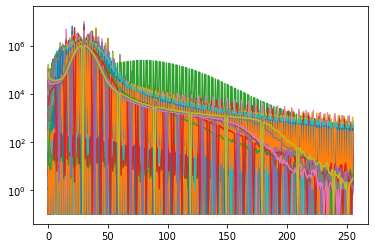

In [9]:
# brightfiled data of figures
if False:
    img_data = {}
    for fn in fns:
        info = read_image(fdn_mat + fn)
        data = info['data']
        wls = info['wavelengths']
        for i, wl in enumerate(wls):
            dd = (data[i] / data[i].max() * 255).astype(np.uint8)
            key = fn.split('.')[0] + '_' + str(wl[0]) + '_' + str(wl[1])
            img_data[key] = dd 

    fig, ax = plt.subplots()
    for a in img_data.values():
        y = np.bincount(a.ravel())
        ymax = y.argmax()
        a_aj = (a * 30.0 / ymax).astype(np.uint8)
        y = np.bincount(a_aj.ravel())

        x = np.arange(len(y))
        ax.plot(x, y+0.1)
    ax.set_yscale('log')

### plot normalized brightfield figures  

In [5]:
# normalized brightfield data of figures  
if False:
    img_data_nor = {}
    for i, fn in enumerate(fns):
        print(i)
        info = read_image(fdn_mat + fn)
        data = info['data']
        wls = info['wavelengths']
        for i, wl in enumerate(wls):
            key = fn.split('.')[0] + '_' + str(wl[0]) + '_' + str(wl[1])
            dd = (data[i] / data[i].max() * 255).astype(np.uint8)
            dd = (dd * 30.0 / np.bincount(dd.ravel()).argmax()).astype(np.uint8)# normalized brightfield
            img_data_nor[key] = dd
            img = Image.fromarray(dd)
            img.save(fdn_images + 'Nor_BF/' + key + '.tiff')
            img.save(fdn_images +'Nor_BF/' +  key + '.png')

In [14]:
fns_plot = ['dish2_U7.mat']
for i, fn in enumerate(fns_plot):
    info = read_image(fdn_mat + fn)
    data = info['data']
    wls = info['wavelengths']
    sample = fn.split('.')[0]
    print('sample {}: {}'.format(i, sample))
    for j, wl in enumerate(wls):
        wl_name = str(wl[0]) + '_' + str(wl[1])
        dd = (data[i] / data[i].max() * 255).astype(np.uint8)
        dd = (dd * 30.0 / np.bincount(dd.ravel()).argmax()).astype(np.uint8)# normalized brightfield
        img = Image.fromarray(dd.T)
        fni = fdn_images + 'brightfield/' + sample
        if not os.path.exists(fni):
            os.mkdir(fni)
        img.save(fni + '/' + wl_name + '.png')

Read metadata about excitation/emission lambdas
Read image data
sample 0: dish2_U7


### concat a fake RGB figure using the 1, 6, 13 channel of normalized figures

In [21]:
seg_fnd = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/Nor_BF/'
for fn in fns:
    rgb = []
    for i, wl in enumerate(wls):
        if i in [1, 6, 13]:
            key = fn.split('.')[0] + '_' + str(wl[0]) + '_' + str(wl[1])
            img = cv2.imread(seg_fnd + key + '.tiff', 2)
            rgb.append(img.T)
    rgb = np.dstack(tuple(rgb))
    rgb_uint8 = rgb.astype(np.uint8)  #right, Janna, not 256
    img = Image.fromarray(rgb_uint8)
    img.save(fdn_images + 'Nor_RGB_figs_1_6_13/'+ fn.split('.')[0] + '.png')

### concat a fake RGB figure using the 3, 5, 6 channel of normalized figures

In [22]:
seg_fnd = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/Nor_BF/'
for fn in fns:
    rgb = []
    for i, wl in enumerate(wls):
        if i in [3, 5, 6]:
            key = fn.split('.')[0] + '_' + str(wl[0]) + '_' + str(wl[1])
            img = cv2.imread(seg_fnd + key + '.tiff', 2)
            rgb.append(img.T)
    rgb = np.dstack(tuple(rgb))
    rgb_uint8 = rgb.astype(np.uint8)  #right, Janna, not 256
    img = Image.fromarray(rgb_uint8)
    img.save(fdn_images + 'Nor_RGB_figs_3_5_6/'+ fn.split('.')[0] + '.png')

# load npz images

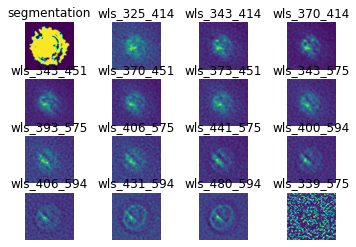

In [119]:
img = np.load('/home/yike/phd/cancer_cells_img_seq/figures/segmentation/cancer100cells/C6_S40.npz')
fig, axs = plt.subplots(4, 4)
axs = axs.ravel()

for i, ax in enumerate(axs):
    ax.imshow(img[img.files[i]])
    ax.autoscale(False)
    ax.set_title(img.files[i])
    ax.axis('off')

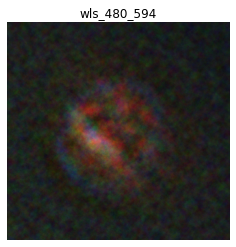

In [62]:
data = np.empty(list(img[img.files[0]].shape) + [3])
for i, j in enumerate([4, 9, 14]):
    dd = (img[img.files[j]] / img[img.files[j]].max() * 255).astype(np.uint8)
    dd = (dd * 30.0 / np.bincount(dd.ravel()).argmax()).astype(np.uint8)# normalized brightfield
    data[:, :, i] = dd
data = data.astype('uint8')

fig, ax = plt.subplots()
ax.imshow(data)
ax.set_title('wls_480_594')
ax.axis('off')
ax.autoscale(False)

(-0.5, 325.5, 318.5, -0.5)

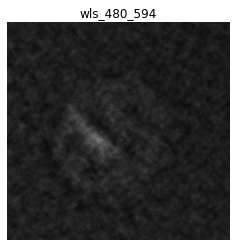

In [63]:
fig, ax = plt.subplots()
dd = (img[img.files[12]] / img[img.files[12]].max() * 255).astype(np.uint8)
dd = (dd * 30.0 / np.bincount(dd.ravel()).argmax()).astype(np.uint8)# normalized brightfield
ax.imshow(dd, cmap='gray', vmin=0, vmax=256)
ax.set_title('wls_480_594')
ax.axis('off')

# create new segmentation according to the coordinates from semi_automatic_YK.py

In [64]:
with open('/home/yike/phd/cancer_cells_img_seq/figures/segmentation/cancer100cells/coordinates.txt') as f:
    next(f)
    for line in f:
        sample = line.split('\t')[0]
        coords = line.split('\t')[1].rstrip(']]\n').lstrip('[[').split('], [')
        coords = [(float(i.split(',')[0]), float(i.split(',')[1])) for i in coords]

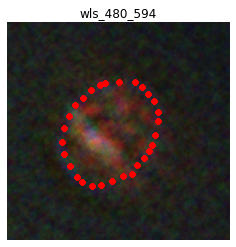

In [65]:
fig, ax = plt.subplots()
ax.imshow(data)
ax.set_title('wls_480_594')
ax.axis('off')
for co in coords:
    ax.scatter(list(map(itemgetter(0), coords)), list(map(itemgetter(1), coords)), c='r', s=20)
ax.autoscale(False)

(-0.5, 325.5, 318.5, -0.5)

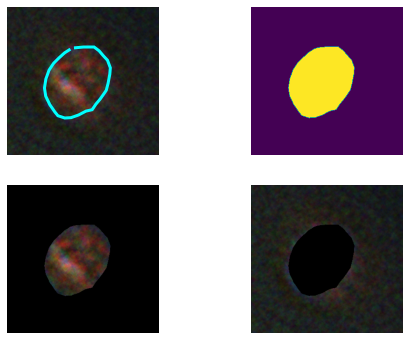

In [108]:
# plots
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2)
gs.update(wspace=0.2, hspace= 0.2)

# image + patch
ax = plt.subplot(gs[0])
ax.imshow(data)
patch = patches.PathPatch(path, facecolor="None", edgecolor="cyan", lw=3)
ax.add_patch(patch)
ax.axis('off')

# mask
ax = plt.subplot(gs[1])
ax.imshow(mask)
ax.axis('off')

# filter image with mask
ax = plt.subplot(gs[2])
ax.imshow(data * mask[..., np.newaxis])
ax.axis('off')

# remove mask from image
ax = plt.subplot(gs[3])
ax.imshow(data * ~mask[..., np.newaxis])
ax.axis('off')

This is the 14 cell C3_S1


(-0.5, 376.5, 371.5, -0.5)

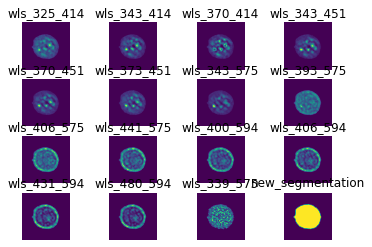

In [168]:
image = np.load('/home/yike/phd/cancer_cells_img_seq/figures/segmentation/cancer100cells/C3_S1.npz')
fn = 'C3_S1.npz'
sample = fn.split('.')[0]

print(f'This is the {i} cell {sample}')
fig, axs = plt.subplots(4, 4)
axs = axs.ravel()

for i, file in enumerate(image.files[1:-1]):
    axs[i].imshow(image[file] * (image['new_segmentation']))
    axs[i].set_title(file)
    axs[i].axis('off')
axs[-1].imshow(image[image.files[-1]])
axs[-1].set_title('new_segmentation')
axs[-1].axis('off')

In [223]:
with open('/home/yike/phd/cancer_cells_img_seq/figures/segmentation/cancer100cells/2/coordinates.txt','r') as r:
    lines2=r.readlines()
with open('/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/cancer100cells/new_segmentation/coordinates.txt','a') as w:
    for l in lines2[1:]:
        w.write(l)